In [2]:
%pip install pandas numpy matplotlib scikit-learn

   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   -------------------------- ------------- 7.3/11.1 MB 37.6 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 30.4 MB/s  0:00:00
   ---------------------------------------- 0.0/12.4 MB ? eta -:--:--
   -------------------------- ------------- 8.4/12.4 MB 40.6 MB/s eta 0:00:01
   ---------------------------------------  12.3/12.4 MB 36.2 MB/s eta 0:00:01
   ---------------------------------------- 12.4/12.4 MB 24.9 MB/s  0:00:00
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   ---------------------------------------  8.1/8.3 MB 40.1 MB/s eta 0:00:01
   ---------------------------------------- 8.3/8.3 MB 30.8 MB/s  0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------- ----- 7.1/8.1 MB 33.6 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 21.5 MB/s  0:00:00
   ------------------------------

Customer Reviews Classification & Customer Segmentation

Στόχοι
1) Μετατροπή της κλίμακας rating (1–5) σε 3 κατηγορίες (Bad / Mediocre / Good) και εκπαίδευση μοντέλων που προβλέπουν την κατηγορία από το κείμενο της κριτικής.
2) Καθαρισμός/μηχανική χαρακτηριστικών για το dataset πελατών και ομαδοποίηση με K-Means για υποστήριξη στοχευμένου marketing.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)


Matplotlib is building the font cache; this may take a moment.


# Customer Reviews Classification & Customer Segmentation

## Εισαγωγή

Η παρούσα εργασία στοχεύει στην ανάλυση δεδομένων ηλεκτρονικού εμπορίου με χρήση τεχνικών μηχανικής μάθησης.
Αρχικά, μελετάται το περιεχόμενο κριτικών πελατών και η μετατροπή της αριθμητικής βαθμολογίας σε κατηγορίες
συναισθήματος. Στη συνέχεια, πραγματοποιείται ομαδοποίηση πελατών με σκοπό την υποστήριξη στοχευμένων
στρατηγικών marketing.


In [4]:
items = pd.read_csv("data/20191226-items.csv")
reviews = pd.read_csv("data/20191226-reviews.csv")
customers = pd.read_csv("data/customers.csv")

items.head(), reviews.head(), customers.head()


(         asin     brand                                              title  \
 0  B0000SX2UC       NaN  Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...   
 1  B0009N5L7K  Motorola                                Motorola I265 phone   
 2  B000SKTZ0S  Motorola  MOTOROLA C168i AT&T CINGULAR PREPAID GOPHONE C...   
 3  B001AO4OUC  Motorola              Motorola i335 Cell Phone Boost Mobile   
 4  B001DCJAJG  Motorola      Motorola V365 no contract cellular phone AT&T   
 
                                                  url                                              image  rating  \
 0  https://www.amazon.com/Dual-Band-Tri-Mode-Acti...  https://m.media-amazon.com/images/I/2143EBQ210...     3.0   
 1  https://www.amazon.com/Motorola-i265-I265-phon...  https://m.media-amazon.com/images/I/419WBAVDAR...     3.0   
 2  https://www.amazon.com/MOTOROLA-C168i-CINGULAR...  https://m.media-amazon.com/images/I/71b+q3ydkI...     2.7   
 3  https://www.amazon.com/Motorola-i335-Phone-Boo...  https

In [ ]:
    ## 1. Έλεγχος δομής & ποιότητας δεδομένων
Σε αυτό το βήμα ελέγχουμε τύπους μεταβλητών, ελλείπουσες τιμές και βασικές περιγραφικές πληροφορίες ώστε να σχεδιάσουμε σωστά την προεπεξεργασία.


In [5]:
print("ITEMS:", items.shape)
display(items.head(3))
display(items.isna().sum().sort_values(ascending=False).head(10))

print("\nREVIEWS:", reviews.shape)
display(reviews.head(3))
display(reviews.isna().sum().sort_values(ascending=False).head(10))

print("\nCUSTOMERS:", customers.shape)
display(customers.head(3))
display(customers.isna().sum().sort_values(ascending=False).head(10))


ITEMS: (720, 10)


,asin,brand,title,url,image,rating,reviewUrl,totalReviews,price,originalPrice
0,B0000SX2UC,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.00,0.0
1,B0009N5L7K,Motorola,Motorola I265 phone,https://www.amazon.com/Motorola-i265-I265-phon...,https://m.media-amazon.com/images/I/419WBAVDAR...,3.0,https://www.amazon.com/product-reviews/B0009N5L7K,7,49.95,0.0
2,B000SKTZ0S,Motorola,MOTOROLA C168i AT&T CINGULAR PREPAID GOPHONE C...,https://www.amazon.com/MOTOROLA-C168i-CINGULAR...,https://m.media-amazon.com/images/I/71b+q3ydkI...,2.7,https://www.amazon.com/product-reviews/B000SKTZ0S,22,99.99,0.0


brand            4
asin             0
title            0
url              0
image            0
rating           0
reviewUrl        0
totalReviews     0
price            0
originalPrice    0
dtype: int64


REVIEWS: (67986, 8)


,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0


helpfulVotes    40771
title              29
body               26
name                3
date                0
rating              0
asin                0
verified            0
dtype: int64


CUSTOMERS: (2240, 1)


,ID\tYear_Birth\tEducation\tMarital_Status\tIncome\tKidhome\tTeenhome\tDt_Customer\tRecency\tMntWines\tMntFruits\tMntMeatProducts\tMntFishProducts\tMntSweetProducts\tMntGoldProds\tNumDealsPurchases\tNumWebPurchases\tNumCatalogPurchases\tNumStorePurchases\tNumWebVisitsMonth\tAcceptedCmp3\tAcceptedCmp4\tAcceptedCmp5\tAcceptedCmp1\tAcceptedCmp2\tComplain\tZ_CostContact\tZ_Revenue\tResponse
0,5524\t1957\tGraduation\tSingle\t58138\t0\t0\t0...
1,2174\t1954\tGraduation\tSingle\t46344\t1\t1\t0...
2,4141\t1965\tGraduation\tTogether\t71613\t0\t0\...


ID\tYear_Birth\tEducation\tMarital_Status\tIncome\tKidhome\tTeenhome\tDt_Customer\tRecency\tMntWines\tMntFruits\tMntMeatProducts\tMntFishProducts\tMntSweetProducts\tMntGoldProds\tNumDealsPurchases\tNumWebPurchases\tNumCatalogPurchases\tNumStorePurchases\tNumWebVisitsMonth\tAcceptedCmp3\tAcceptedCmp4\tAcceptedCmp5\tAcceptedCmp1\tAcceptedCmp2\tComplain\tZ_CostContact\tZ_Revenue\tResponse    0
dtype: int64

## 2. Συνένωση (Join) των datasets & δημιουργία της μεταβλητής Cat_Rating
Ενώνουμε τα datasets βάσει του κοινού κλειδιού `asin`. Στη συνέχεια μετατρέπουμε τη βαθμολογία 1–5 σε 3 κατηγορίες:
- 1–2: Bad
- 3: Mediocre
- 4–5: Good


In [6]:
# Join reviews με επιλεγμένα πεδία από items (ώστε να κρατάμε και πληροφορίες προϊόντος)
df = reviews.merge(
    items[["asin", "brand", "title", "price", "rating", "totalReviews"]],
    on="asin",
    how="left",
    suffixes=("_review", "_item")
)

print(df.shape)
display(df.head(3))


(67986, 13)


,asin,name,rating_review,date,verified,title_review,body,helpfulVotes,brand,title_item,price,rating_item,totalReviews
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,0.0,3.0,14
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,0.0,3.0,14
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,0.0,3.0,14


In [8]:
print("Columns in reviews:")
print(reviews.columns.tolist())

print("\nColumns in items:")
print(items.columns.tolist())

print("\nColumns in df (after merge):")
print(df.columns.tolist())


Columns in reviews:
['asin', 'name', 'rating', 'date', 'verified', 'title', 'body', 'helpfulVotes']

Columns in items:
['asin', 'brand', 'title', 'url', 'image', 'rating', 'reviewUrl', 'totalReviews', 'price', 'originalPrice']

Columns in df (after merge):
['asin', 'name', 'rating_review', 'date', 'verified', 'title_review', 'body', 'helpfulVotes', 'brand', 'title_item', 'price', 'rating_item', 'totalReviews']


In [9]:
# Βρες αυτόματα ποια στήλη είναι η βαθμολογία της κριτικής
possible_rating_cols = ["rating", "Rating", "stars", "score", "overall", "reviewRating", "rating_review"]
rating_col = next((c for c in possible_rating_cols if c in df.columns), None)

if rating_col is None:
    # Αν δεν τη βρει, προσπάθησε να βρει οποιαδήποτε στήλη που περιέχει τη λέξη 'rating'
    candidates = [c for c in df.columns if "rating" in c.lower()]
    raise ValueError(f"Δεν βρέθηκε στήλη rating. Πιθανές στήλες: {candidates}")

print("✅ Χρησιμοποιώ ως rating τη στήλη:", rating_col)

# Μετατροπή σε numeric
df[rating_col] = pd.to_numeric(df[rating_col], errors="coerce")

# Δημιουργία Cat_Rating
def to_cat(r):
    if pd.isna(r):
        return np.nan
    if r <= 2:
        return "Bad"
    elif r == 3:
        return "Mediocre"
    else:
        return "Good"

df["Cat_Rating"] = df[rating_col].apply(to_cat)

display(df[["asin", rating_col, "Cat_Rating"]].head(10))
display(df["Cat_Rating"].value_counts(dropna=False))



✅ Χρησιμοποιώ ως rating τη στήλη: rating_review


,asin,rating_review,Cat_Rating
0,B0000SX2UC,3,Mediocre
1,B0000SX2UC,1,Bad
2,B0000SX2UC,5,Good
3,B0000SX2UC,3,Mediocre
4,B0000SX2UC,4,Good
5,B0000SX2UC,4,Good
6,B0000SX2UC,5,Good
7,B0000SX2UC,4,Good
8,B0000SX2UC,5,Good
9,B0000SX2UC,3,Mediocre


Cat_Rating
Good        46576
Bad         16658
Mediocre     4752
Name: count, dtype: int64

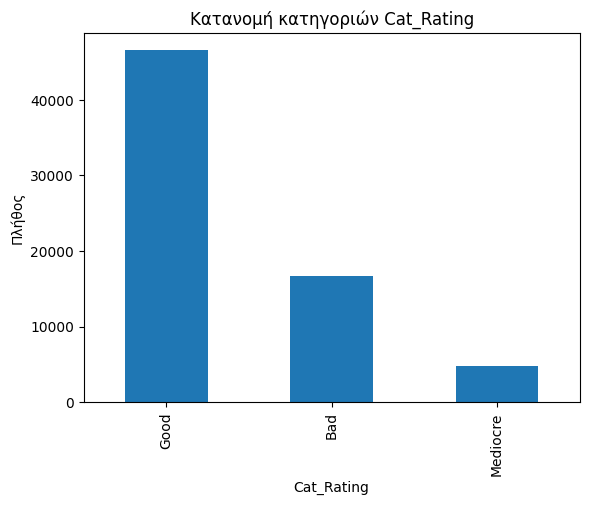

In [10]:
counts = df["Cat_Rating"].value_counts()

plt.figure()
counts.plot(kind="bar")
plt.title("Κατανομή κατηγοριών Cat_Rating")
plt.xlabel("Cat_Rating")
plt.ylabel("Πλήθος")
plt.show()


## 3. Προετοιμασία Κειμένου για Classification

Στο στάδιο αυτό ορίζονται:
- ως μεταβλητή εισόδου (X) το κείμενο της κριτικής
- ως μεταβλητή στόχου (y) η κατηγορία συναισθήματος Cat_Rating


In [12]:
# Δείξε όλες τις στήλες του df
print(df.columns.tolist())


['asin', 'name', 'rating_review', 'date', 'verified', 'title_review', 'body', 'helpfulVotes', 'brand', 'title_item', 'price', 'rating_item', 'totalReviews', 'Cat_Rating']


In [13]:
# Βρες αυτόματα τη στήλη που περιέχει το κείμενο της κριτικής
possible_text_cols = ["reviewText", "review", "text", "content", "summary", "body"]

text_col = next((c for c in possible_text_cols if c in df.columns), None)

if text_col is None:
    # Αν δεν βρεθεί, δοκίμασε να εντοπίσεις στήλες που μοιάζουν
    candidates = [c for c in df.columns if any(k in c.lower() for k in ["review", "text", "content", "summary", "body"])]
    raise ValueError(f"❌ Δεν βρέθηκε στήλη κειμένου. Πιθανές στήλες: {candidates}")

print("✅ Χρησιμοποιώ ως κείμενο τη στήλη:", text_col)

# Dataset για classification
df_clf = df[[text_col, "Cat_Rating"]].dropna()

print("Shape df_clf:", df_clf.shape)
df_clf.head()


✅ Χρησιμοποιώ ως κείμενο τη στήλη: body
Shape df_clf: (67960, 2)


,body,Cat_Rating
0,I had the Samsung A600 for awhile which is abs...,Mediocre
1,Due to a software issue between Nokia and Spri...,Bad
2,"This is a great, reliable phone. I also purcha...",Good
3,"I love the phone and all, because I really did...",Mediocre
4,The phone has been great for every purpose it ...,Good


In [15]:
# 3.2 Ορισμός X (κείμενο) και y (Cat_Rating)
X = df_clf[text_col]
y = df_clf["Cat_Rating"]

print("Πλήθος δειγμάτων:", X.shape[0])
print(y.value_counts())


Πλήθος δειγμάτων: 67960
Cat_Rating
Good        46558
Bad         16650
Mediocre     4752
Name: count, dtype: int64


### 3.3 Διαχωρισμός σε Training / Test set (Stratified Split)
Διατηρούμε την ίδια αναλογία κατηγοριών (Bad/Mediocre/Good) σε train και test.


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))
print("\nTrain distribution:\n", y_train.value_counts(normalize=True))
print("\nTest distribution:\n", y_test.value_counts(normalize=True))


Train size: 54368
Test size: 13592

Train distribution:
 Cat_Rating
Good        0.685072
Bad         0.244997
Mediocre    0.069931
Name: proportion, dtype: float64

Test distribution:
 Cat_Rating
Good        0.685109
Bad         0.244997
Mediocre    0.069894
Name: proportion, dtype: float64


### 3.4 TF-IDF Μετατροπή Κειμένου σε Χαρακτηριστικά
Χρησιμοποιούμε TF-IDF με unigrams + bigrams και stopwords (English) για καλύτερη αναπαράσταση κειμένου.


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words="english",
    lowercase=True,
    max_features=20000,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF test shape:", X_test_tfidf.shape)


TF-IDF train shape: (54368, 20000)
TF-IDF test shape: (13592, 20000)


## 4. Μοντέλο 1: Decision Tree
Εκπαιδεύουμε Decision Tree πάνω στα TF-IDF χαρακτηριστικά και αξιολογούμε με classification report & confusion matrix.


Decision Tree - Classification Report:

              precision    recall  f1-score   support

         Bad       0.62      0.67      0.65      3330
        Good       0.84      0.89      0.86      9312
    Mediocre       0.20      0.05      0.08       950

    accuracy                           0.77     13592
   macro avg       0.56      0.53      0.53     13592
weighted avg       0.74      0.77      0.75     13592



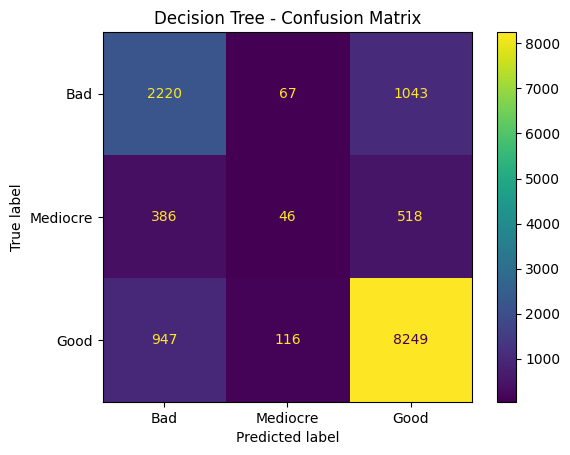

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

tree = DecisionTreeClassifier(
    random_state=42,
    max_depth=30,
    min_samples_leaf=2
)

tree.fit(X_train_tfidf, y_train)
y_pred_tree = tree.predict(X_test_tfidf)

print("Decision Tree - Classification Report:\n")
print(classification_report(y_test, y_pred_tree))

cm = confusion_matrix(y_test, y_pred_tree, labels=["Bad", "Mediocre", "Good"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bad", "Mediocre", "Good"])
disp.plot()
plt.title("Decision Tree - Confusion Matrix")
plt.show()


## 5. Μοντέλο 2: KNN (δοκιμή διαφορετικών k)
Δοκιμάζουμε διαφορετικά k και επιλέγουμε το καλύτερο βάσει Accuracy στο test set.


k=1 -> accuracy=0.7017
k=3 -> accuracy=0.7187
k=5 -> accuracy=0.7248
k=7 -> accuracy=0.7254
k=9 -> accuracy=0.7241
k=11 -> accuracy=0.7222
k=15 -> accuracy=0.7203
k=21 -> accuracy=0.7178


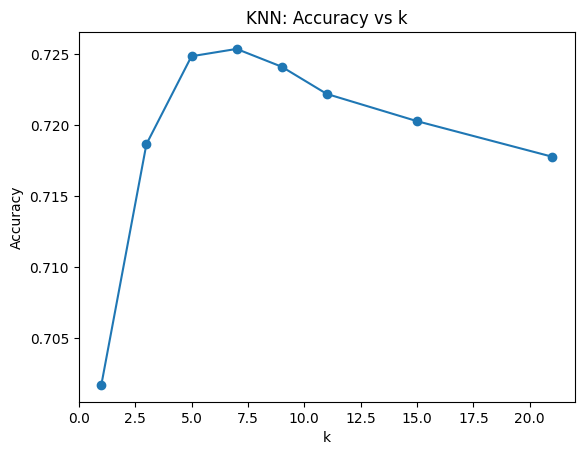


✅ Best k based on accuracy: 7


In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

k_values = [1, 3, 5, 7, 9, 11, 15, 21]
accs = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights="distance")
    knn.fit(X_train_tfidf, y_train)
    preds = knn.predict(X_test_tfidf)
    acc = accuracy_score(y_test, preds)
    accs.append(acc)
    print(f"k={k} -> accuracy={acc:.4f}")

plt.figure()
plt.plot(k_values, accs, marker="o")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("KNN: Accuracy vs k")
plt.show()

best_k = k_values[int(np.argmax(accs))]
print("\n✅ Best k based on accuracy:", best_k)


In [20]:
best_k = 7


KNN (k=7) Classification Report:

              precision    recall  f1-score   support

         Bad       0.81      0.18      0.29      3330
        Good       0.72      0.99      0.83      9312
    Mediocre       0.87      0.07      0.13       950

    accuracy                           0.73     13592
   macro avg       0.80      0.41      0.42     13592
weighted avg       0.75      0.73      0.65     13592



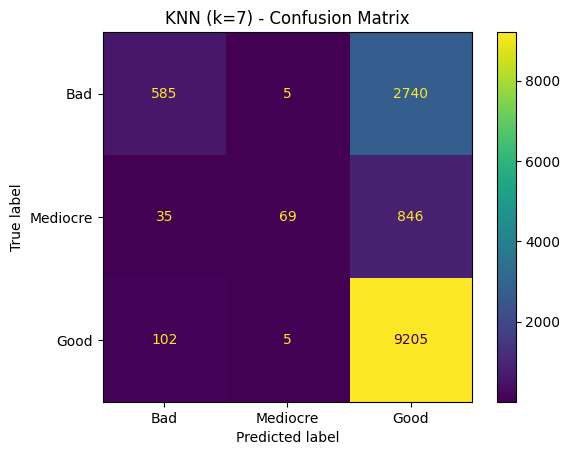

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

knn_best = KNeighborsClassifier(n_neighbors=best_k, weights="distance")
knn_best.fit(X_train_tfidf, y_train)

y_pred_knn = knn_best.predict(X_test_tfidf)

print(f"KNN (k={best_k}) Classification Report:\n")
print(classification_report(y_test, y_pred_knn))

cm = confusion_matrix(y_test, y_pred_knn, labels=["Bad", "Mediocre", "Good"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bad", "Mediocre", "Good"])
disp.plot()
plt.title(f"KNN (k={best_k}) - Confusion Matrix")
plt.show()


Σύγκριση Decision Tree vs KNN
Συγκρίνουμε τα μοντέλα με Accuracy και Macro F1-score (λόγω ανισορροπίας κλάσεων).

In [35]:
from sklearn.metrics import accuracy_score, f1_score

# Decision Tree predictions: y_pred_tree
# KNN predictions: y_pred_knn

acc_tree = accuracy_score(y_test, y_pred_tree)
f1_tree  = f1_score(y_test, y_pred_tree, average="macro")

acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn  = f1_score(y_test, y_pred_knn, average="macro")

print("=== Σύγκριση Μοντέλων ===")
print(f"Decision Tree: accuracy={acc_tree:.4f}, macroF1={f1_tree:.4f}")
print(f"KNN (k={best_k}): accuracy={acc_knn:.4f}, macroF1={f1_knn:.4f}")


=== Σύγκριση Μοντέλων ===
Decision Tree: accuracy=0.7736, macroF1=0.5286
KNN (k=7): accuracy=0.7254, macroF1=0.4186


## 6. Ομαδοποίηση Πελατών (Customer Segmentation)


## 6. Customer Segmentation με K-Means


### 6.1 Φόρτωση και αρχική εξερεύνηση δεδομένων πελατών


In [22]:
# 6.1 Φόρτωση δεδομένων πελατών

customers = pd.read_csv("data/customers.csv")

# Βασική επισκόπηση
customers.shape


(2240, 1)

### Οπτικοποίηση Κατηγορικών Μεταβλητών

Στο παρακάτω στάδιο παρουσιάζονται γραφήματα για βασικές κατηγορικές μεταβλητές
(Εκπαίδευση και Οικογενειακή Κατάσταση), ώστε να γίνει κατανοητή η κατανομή
των πελατών πριν την προεπεξεργασία και την ομαδοποίηση.


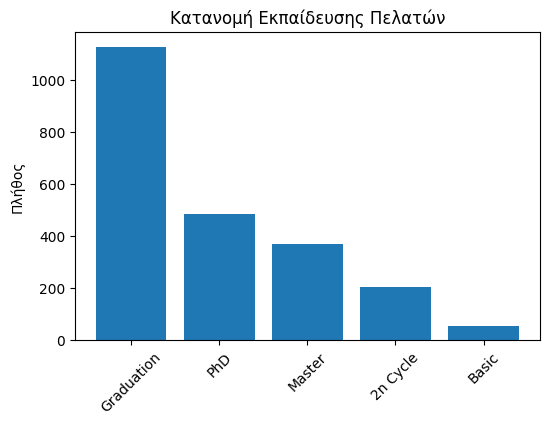

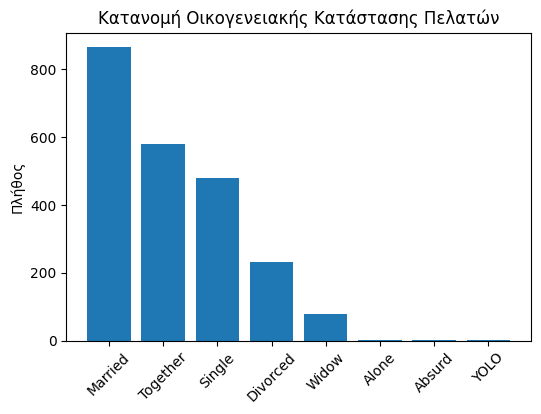

In [37]:
import matplotlib.pyplot as plt

# Κατανομή Εκπαίδευσης
edu_counts = customers["Education"].value_counts()

plt.figure(figsize=(6,4))
plt.bar(edu_counts.index, edu_counts.values)
plt.title("Κατανομή Εκπαίδευσης Πελατών")
plt.xticks(rotation=45)
plt.ylabel("Πλήθος")
plt.show()

# Κατανομή Οικογενειακής Κατάστασης
mar_counts = customers["Marital_Status"].value_counts()

plt.figure(figsize=(6,4))
plt.bar(mar_counts.index, mar_counts.values)
plt.title("Κατανομή Οικογενειακής Κατάστασης Πελατών")
plt.xticks(rotation=45)
plt.ylabel("Πλήθος")
plt.show()


“6.2 Μηχανική Δεδομένων & Καθαρισμός

In [38]:
import pandas as pd
import numpy as np

# Δουλεύουμε σε αντίγραφο
cust = customers.copy()

# 1) Μετατροπή Dt_Customer σε ημερομηνία (για να πάρουμε reference year)
cust["Dt_Customer"] = pd.to_datetime(cust["Dt_Customer"], dayfirst=True, errors="coerce")
ref_year = int(cust["Dt_Customer"].dt.year.max())  # π.χ. 2014

# 2) Ηλικία
cust["Age"] = ref_year - cust["Year_Birth"]

# 3) Παιδιά (Kidhome + Teenhome)
cust["Children"] = cust["Kidhome"] + cust["Teenhome"]

# 4) Δαπάνες (σύνολο σε όλες τις κατηγορίες)
spend_cols = ["MntWines","MntFruits","MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds"]
cust["Spending"] = cust[spend_cols].sum(axis=1)

# 5) Καθαρισμός Οικογενειακής Κατάστασης
# - σβήνουμε σπάνιες κατηγορίες (threshold=10 μπορείς να το αλλάξεις)
vc = cust["Marital_Status"].value_counts()
rare = vc[vc < 10].index
cust = cust[~cust["Marital_Status"].isin(rare)].copy()

# - Married + Together -> Couple
cust["Marital_Status_Clean"] = cust["Marital_Status"].replace({
    "Married": "Couple",
    "Together": "Couple"
})

# 6) Εκπαίδευση σε 3 κατηγορίες
cust["Education_3"] = cust["Education"].replace({
    "Basic": "Basic",
    "2n Cycle": "Basic",
    "Graduation": "Graduate",
    "Master": "Postgrad",
    "PhD": "Postgrad"
})

# 7) Missing values (Income έχει συνήθως NaN)
# Επιλογή: συμπλήρωση με median
cust["Income"] = cust["Income"].fillna(cust["Income"].median())

# Έλεγχος ότι δεν έχουμε NaN
cust.isna().sum().sort_values(ascending=False).head(10)


ID                0
Year_Birth        0
Education         0
Marital_Status    0
Income            0
Kidhome           0
Teenhome          0
Dt_Customer       0
Recency           0
MntWines          0
dtype: int64

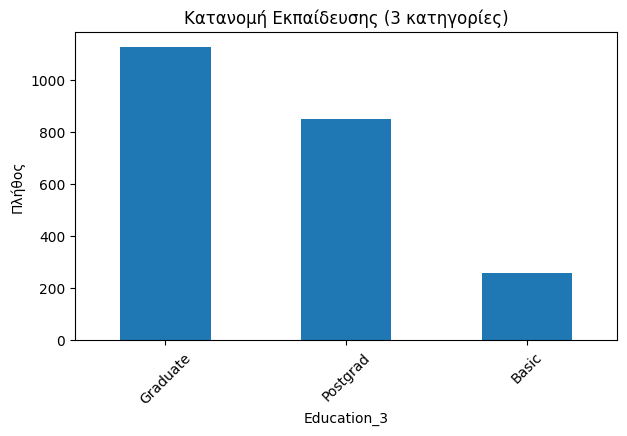

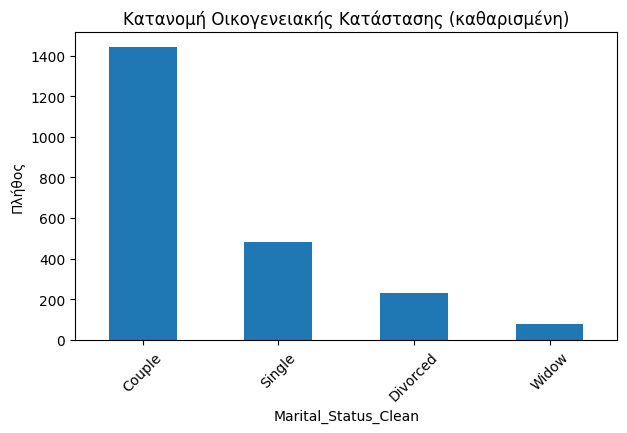

In [39]:
import matplotlib.pyplot as plt

# Education (3 categories)
plt.figure(figsize=(7,4))
cust["Education_3"].value_counts().plot(kind="bar")
plt.title("Κατανομή Εκπαίδευσης (3 κατηγορίες)")
plt.ylabel("Πλήθος")
plt.xticks(rotation=45)
plt.show()

# Marital_Status (clean)
plt.figure(figsize=(7,4))
cust["Marital_Status_Clean"].value_counts().plot(kind="bar")
plt.title("Κατανομή Οικογενειακής Κατάστασης (καθαρισμένη)")
plt.ylabel("Πλήθος")
plt.xticks(rotation=45)
plt.show()


**Σχόλιο κατηγορικών μεταβλητών**

Από τα παραπάνω γραφήματα παρατηρούμε ότι:
- Η πλειονότητα των πελατών έχει επίπεδο εκπαίδευσης *Graduation*, ενώ λιγότεροι πελάτες ανήκουν στις κατηγορίες *PhD* και *Master*.
- Στην οικογενειακή κατάσταση κυριαρχούν οι κατηγορίες *Married/Together* και *Single*, ενώ ορισμένες κατηγορίες εμφανίζουν πολύ μικρό πλήθος.

Οι παρατηρήσεις αυτές δικαιολογούν τη συγχώνευση ή/και αφαίρεση σπάνιων κατηγοριών στο επόμενο στάδιο προεπεξεργασίας πριν την εφαρμογή του K-Means.


In [24]:
customers = pd.read_csv("data/customers.csv", sep="\t")

customers.shape


(2240, 29)

In [25]:
customers.head()


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [26]:
# Αντιγραφή dataset για καθαρισμό
cust_clean = customers.copy()

# Στήλες που δεν βοηθούν στο clustering
drop_cols = ["ID", "Dt_Customer"]
cust_clean = cust_clean.drop(columns=drop_cols)

cust_clean.head()


,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,1957,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,1954,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,1965,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,1984,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,1981,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [27]:
cust_clean.isna().sum().sort_values(ascending=False)


Income                 24
Education               0
Year_Birth              0
Marital_Status          0
Kidhome                 0
Teenhome                0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [41]:
cust["Income"] = cust["Income"].fillna(
    cust["Income"].median()
)

cust.isna().sum().max()


np.int64(0)

In [40]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

# Κατηγορικές μεταβλητές (καθαρισμένες)
cat_cols = ["Education_3", "Marital_Status_Clean"]

# Αριθμητικές μεταβλητές
num_cols = cust.drop(columns=cat_cols).select_dtypes(include=np.number).columns

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first"), cat_cols)
    ]
)

# Τελικός πίνακας για K-Means
X_kmeans = preprocessor.fit_transform(cust)

X_kmeans.shape


(2233, 34)

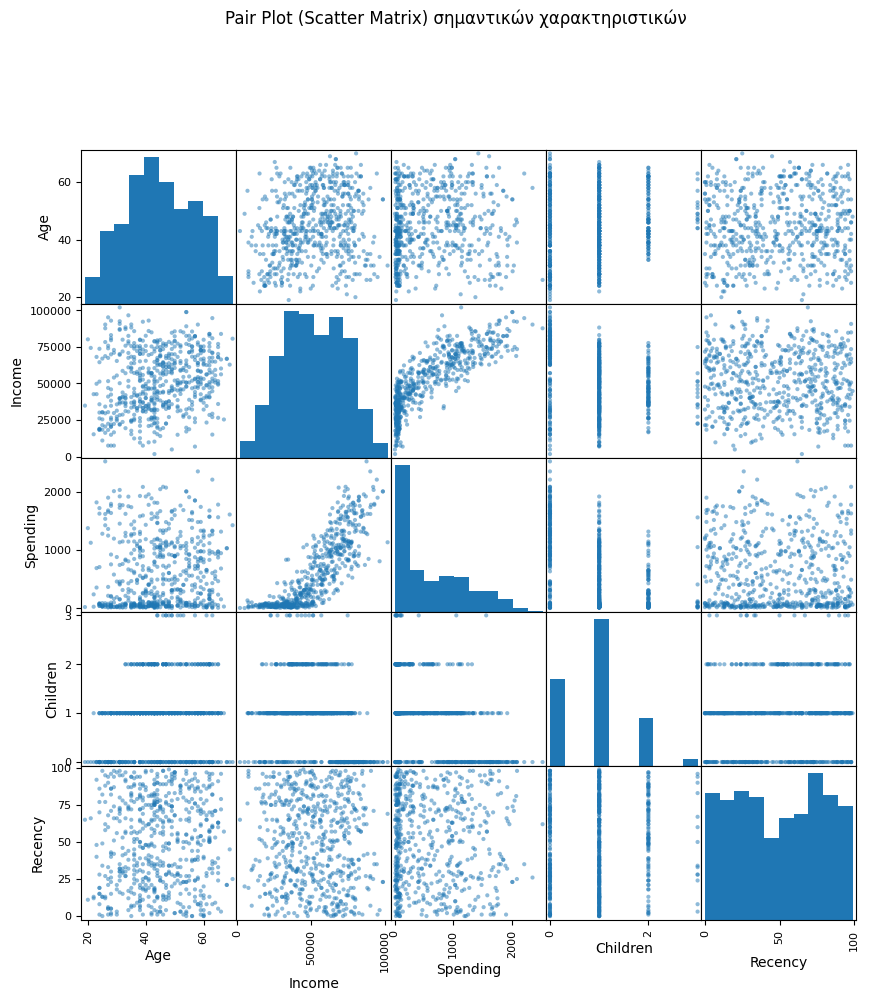

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Διάλεξε 4-5 σημαντικά χαρακτηριστικά (όπως λέει η εκφώνηση)
pair_cols = ["Age", "Income", "Spending", "Children", "Recency"]

df_pair = cust[pair_cols].dropna().sample(600, random_state=42)  # sample για να μη βαραίνει

pd.plotting.scatter_matrix(df_pair, figsize=(10, 10))
plt.suptitle("Pair Plot (Scatter Matrix) σημαντικών χαρακτηριστικών", y=1.02)
plt.show()


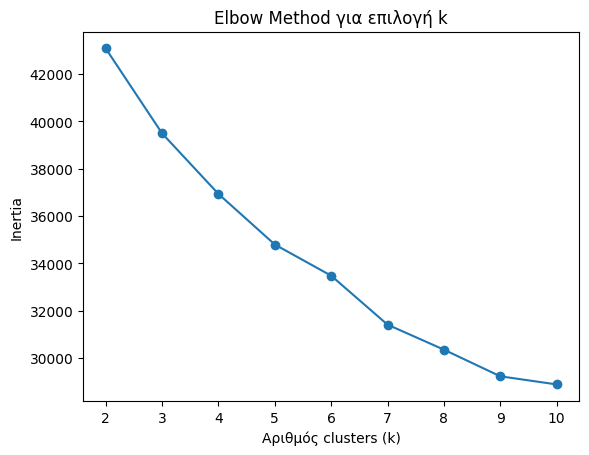

In [30]:
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_kmeans)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(k_range, inertias, marker="o")
plt.xlabel("Αριθμός clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method για επιλογή k")
plt.show()


k=2 → silhouette=0.2485
k=3 → silhouette=0.1729
k=4 → silhouette=0.1735
k=5 → silhouette=0.1814
k=6 → silhouette=0.1806
k=7 → silhouette=0.1133
k=8 → silhouette=0.1182
k=9 → silhouette=0.1184
k=10 → silhouette=0.0837


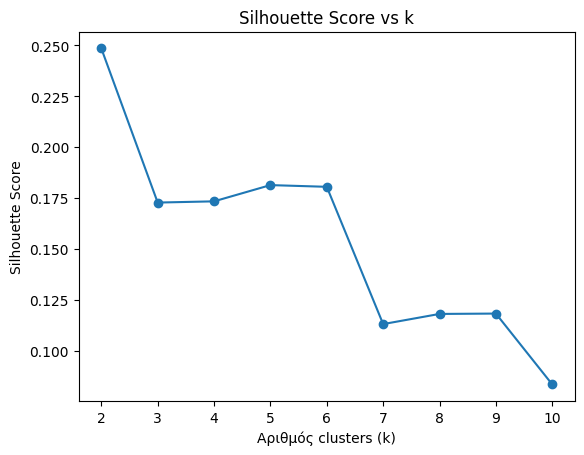

In [31]:
from sklearn.metrics import silhouette_score

sil_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_kmeans)
    score = silhouette_score(X_kmeans, labels)
    sil_scores.append(score)
    print(f"k={k} → silhouette={score:.4f}")

# Γράφημα
plt.figure()
plt.plot(k_range, sil_scores, marker="o")
plt.xlabel("Αριθμός clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs k")
plt.show()


In [32]:
from sklearn.cluster import KMeans

k_final = 5
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)

clusters = kmeans_final.fit_predict(X_kmeans)

cust_clean["Cluster"] = clusters
cust_clean["Cluster"].value_counts()


Cluster
0    1003
4     599
2     447
1     170
3      21
Name: count, dtype: int64

In [33]:
cluster_profile = cust_clean.groupby("Cluster").mean(numeric_only=True)
cluster_profile


,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,
0,1971.925224,34694.282652,0.805583,0.432702,49.270189,39.554337,4.939182,22.742772,7.011964,4.979063,15.057827,2.038883,2.079761,0.537388,3.165503,6.488534,0.075773,0.006979,0.000000,0.000997,0.001994,0.0,3.0,11.0,0.093719
1,1969.205882,81559.558824,0.052941,0.129412,49.794118,876.694118,56.600000,468.417647,77.282353,65.235294,77.400000,1.052941,5.441176,6.023529,8.235294,2.982353,0.135294,0.394118,0.941176,0.447059,0.123529,0.0,3.0,11.0,0.576471
2,1967.917226,74048.391499,0.046980,0.225951,49.284116,492.805369,71.785235,432.606264,105.366890,71.545861,78.418345,1.496644,5.219239,5.787472,8.355705,2.923937,0.060403,0.026846,0.000000,0.109620,0.000000,0.0,3.0,11.0,0.172260
3,1965.095238,45242.285714,0.666667,0.523810,53.047619,169.000000,24.190476,112.476190,25.761905,17.523810,27.476190,2.333333,3.619048,2.047619,5.238095,5.809524,0.095238,0.000000,0.047619,0.000000,0.000000,1.0,3.0,11.0,0.142857
4,1964.262104,57261.862270,0.238731,0.944908,48.377295,447.866444,19.607679,126.525876,27.121870,20.347245,57.959933,3.782972,6.227045,2.954925,7.595993,5.784641,0.058431,0.135225,0.003339,0.030050,0.011686,0.0,3.0,11.0,0.103506


In [34]:
cluster_profile.round(2)


,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,
0,1971.93,34694.28,0.81,0.43,49.27,39.55,4.94,22.74,7.01,4.98,15.06,2.04,2.08,0.54,3.17,6.49,0.08,0.01,0.00,0.00,0.00,0.0,3.0,11.0,0.09
1,1969.21,81559.56,0.05,0.13,49.79,876.69,56.60,468.42,77.28,65.24,77.40,1.05,5.44,6.02,8.24,2.98,0.14,0.39,0.94,0.45,0.12,0.0,3.0,11.0,0.58
2,1967.92,74048.39,0.05,0.23,49.28,492.81,71.79,432.61,105.37,71.55,78.42,1.50,5.22,5.79,8.36,2.92,0.06,0.03,0.00,0.11,0.00,0.0,3.0,11.0,0.17
3,1965.10,45242.29,0.67,0.52,53.05,169.00,24.19,112.48,25.76,17.52,27.48,2.33,3.62,2.05,5.24,5.81,0.10,0.00,0.05,0.00,0.00,1.0,3.0,11.0,0.14
4,1964.26,57261.86,0.24,0.94,48.38,447.87,19.61,126.53,27.12,20.35,57.96,3.78,6.23,2.95,7.60,5.78,0.06,0.14,0.00,0.03,0.01,0.0,3.0,11.0,0.10


### Ερμηνεία Ομάδων Πελατών

- **Cluster 0**: Πελάτες χαμηλότερου εισοδήματος με μικρές αγορές σε όλα τα προϊόντα.
- **Cluster 1**: Υψηλού εισοδήματος πελάτες με πολύ υψηλή κατανάλωση κρασιών και κρέατος.
- **Cluster 2**: Μεσαίου εισοδήματος, ισορροπημένες αγορές σε πολλά προϊόντα.
- **Cluster 3**: Πελάτες με παιδιά στο σπίτι και χαμηλή συνολική κατανάλωση.
- **Cluster 4**: Πελάτες μέσης ηλικίας με επιλεκτικές αγορές (π.χ. κρασιά).
